# AN INTRODUCTARY REVIEW: GRAPH CONVOLUTIONAL NEURAL NETWORKS
### CSCI 5352 Final Project
### CU Boulder Fall Semester 2022
### Kaitlyn McGrew

In [1]:
import torch
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from spektral.data import Dataset, DisjointLoader, Graph
from spektral.data.loaders import SingleLoader
from spektral.transforms import AdjToSpTensor, LayerPreprocess
from spektral.layers import GCNConv
from spektral.models.gcn import GCN

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

2022-12-08 09:41:32.850949: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [399]:
nx.to_numpy_array(nx.barbell_graph(3,1))

array([[0., 1., 1., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 1., 1., 0., 0.],
       [0., 0., 1., 1., 0., 0., 0.]])

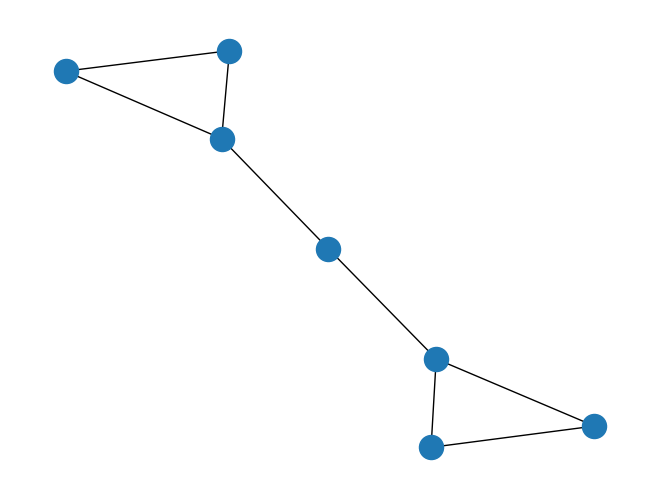

In [393]:
nx.draw(nx.barbell_graph(3,1))

# Karate Club 
code adapted from: https://towardsdatascience.com/lets-talk-about-graph-neural-network-python-libraries-a0b23ec983b0

original paper: https://arxiv.org/pdf/1609.02907.pdf

In [133]:
G_club = nx.karate_club_graph()
labels_club = np.asarray([G_club.nodes[i]['club'] != 'Mr. Hi' for i in G_club.nodes]).astype(np.int64)

In [134]:
from random import uniform

def create_feature(labels, feat_num):
    d = [[] for x in range(feat_num)]
    
    for node in labels:
        if node == 1:
            for feat in d:
                feat.append(uniform(0,.3))
        elif node == 2:
            for feat in d:
                feat.append(uniform(.35,.7))
        else:
            for feat in d:
                feat.append(uniform(.75,1))
    return np.asarray(d).T
        

In [135]:
feature_club = create_feature(labels_club, 5)

In [136]:
feature_club

array([[0.9392534 , 0.76186707, 0.92095413, 0.7637052 , 0.81148538],
       [0.90170132, 0.82550462, 0.80786021, 0.94039772, 0.93048855],
       [0.79559313, 0.9107465 , 0.94127273, 0.82005451, 0.83477956],
       [0.76781742, 0.91624836, 0.8888531 , 0.85972694, 0.99490091],
       [0.96767097, 0.76114927, 0.91633519, 0.9910501 , 0.94167793],
       [0.84495681, 0.8636844 , 0.94339244, 0.97490651, 0.89162402],
       [0.96556476, 0.93638064, 0.99285561, 0.78646136, 0.90672727],
       [0.75283965, 0.83578928, 0.7528619 , 0.83524162, 0.78756623],
       [0.99435159, 0.87504574, 0.86032853, 0.89442802, 0.865068  ],
       [0.0823258 , 0.19519144, 0.05426148, 0.01298553, 0.21665384],
       [0.75861049, 0.83168149, 0.86739849, 0.99141434, 0.7563832 ],
       [0.87402194, 0.9814565 , 0.81375516, 0.87807112, 0.77747814],
       [0.89429661, 0.79670102, 0.9313269 , 0.87991582, 0.93739716],
       [0.86491123, 0.83643381, 0.99578784, 0.84613997, 0.7999181 ],
       [0.0864898 , 0.02763734, 0.

In [137]:
class KarateDataset(Dataset):
    def __init__(self, nodes,feats, **kwargs):
        self.nodes = nodes
        self.feats = feats

        super().__init__(**kwargs)
        
    def read(self):
        output = []
        A = nx.to_numpy_array(G_club)
        Y = labels_club
        le = OneHotEncoder()
        YY = le.fit_transform(Y.reshape(-1,1))

        output.append(
            Graph(x=self.feats.astype("float32"),
                  a=A.astype('float32'), 
                  y=YY.astype('float32').todense()))

        return output

In [138]:
dataset_club = KarateDataset(nodes=np.array(list(G_club.nodes())),
                        feats=feature_club,
                        normalize_x=True,
                        transforms=LayerPreprocess(GCNConv))

In [139]:
dataset_club[0]

Graph(n_nodes=34, n_node_features=5, n_edge_features=None, n_labels=2)

In [140]:
# create train and test masks
node =  np.array(list(G_club.nodes()))
n_nodes = node.shape[0]

X_train, X_test, y_train, y_test = train_test_split(pd.Series(node), 
                                                    pd.Series(labels_club), 
                                                    test_size=0.30, 
                                                    random_state=42)

train_mask = torch.zeros(n_nodes, dtype=torch.float32)
test_mask = torch.zeros(n_nodes, dtype=torch.float32)
train_mask[X_train.index] = 1
test_mask[X_test.index] = 1

In [141]:
seed = 42
tf.random.set_seed(seed=seed) 

def mask_to_weights_torch(mask):
    return mask.type(torch.float32) / np.count_nonzero(mask)

weights_trK, weights_teK = (mask_to_weights_torch(mask) for mask in (train_mask, test_mask))

In [142]:
learning_rate = 1e-2
epochs = 100
patience = 10

In [143]:
model_club = GCN(n_labels=dataset_club.n_labels, channels=5, use_bias=True) 

model_club.compile(optimizer=Adam(learning_rate),
              loss=BinaryCrossentropy(reduction='sum'),
              weighted_metrics=["accuracy"])

In [144]:
loader_trK = SingleLoader(dataset_club, sample_weights=weights_trK)
loader_teK = SingleLoader(dataset_club, sample_weights=weights_teK)

In [146]:
learning_rate = 1e-5

history_club = model_club.fit(loader_trK.load(),
          steps_per_epoch=loader_trK.steps_per_epoch,
          epochs=epochs,
          validation_data=loader_teK.load(),
         validation_steps=loader_teK.steps_per_epoch,
         callbacks=[EarlyStopping(monitor="val_loss",patience=patience, restore_best_weights=True)])

Epoch 1/100
1/1 [==============================] - 1s 591ms/step - loss: 0.8716 - accuracy: 0.5217 - val_loss: 0.7654 - val_accuracy: 0.5455
Epoch 2/100
1/1 [==============================] - 0s 17ms/step - loss: 0.8340 - accuracy: 0.5217 - val_loss: 0.7533 - val_accuracy: 0.5455
Epoch 3/100
1/1 [==============================] - 0s 17ms/step - loss: 0.8018 - accuracy: 0.5217 - val_loss: 0.7424 - val_accuracy: 0.5455
Epoch 4/100
1/1 [==============================] - 0s 41ms/step - loss: 0.7453 - accuracy: 0.6522 - val_loss: 0.7325 - val_accuracy: 0.5455
Epoch 5/100
1/1 [==============================] - 0s 26ms/step - loss: 0.7593 - accuracy: 0.3913 - val_loss: 0.7235 - val_accuracy: 0.4545
Epoch 6/100
1/1 [==============================] - 0s 28ms/step - loss: 0.7168 - accuracy: 0.2609 - val_loss: 0.7159 - val_accuracy: 0.4545
Epoch 7/100
1/1 [==============================] - 0s 24ms/step - loss: 0.7379 - accuracy: 0.2174 - val_loss: 0.7091 - val_accuracy: 0.1818
Epoch 8/100
1/1 [==

In [147]:
loader_fullK = SingleLoader(dataset_club)
pred_club = model_club.predict(loader_fullK.load(), steps=loader_fullK.steps_per_epoch)

1/1 [==============================] - 0s 136ms/step


In [148]:
result_club = pred_club.argmax(axis=1)
confusion_matrix(labels_club, result_club)

array([[17,  0],
       [ 2, 15]])

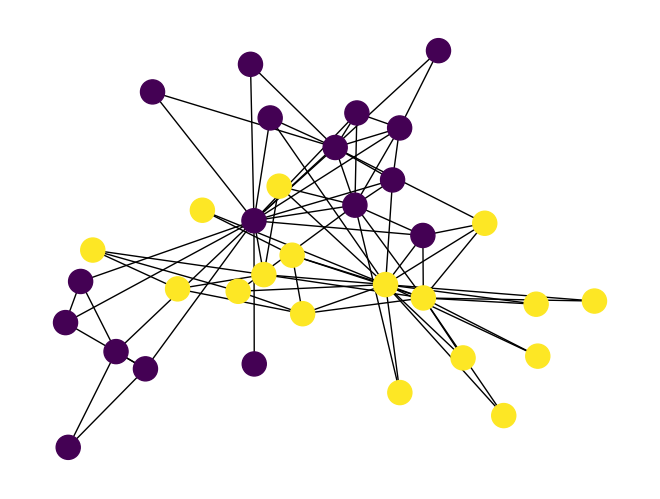

In [149]:
nx.draw(G_club, node_color=labels_club)

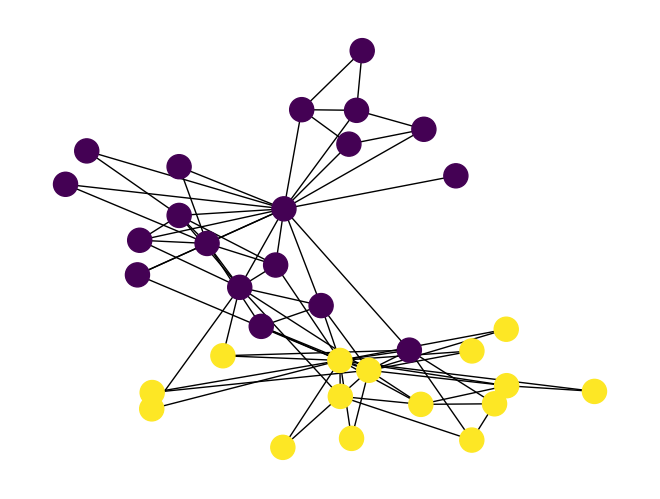

In [387]:
nx.draw(G_club, node_color=result_club)

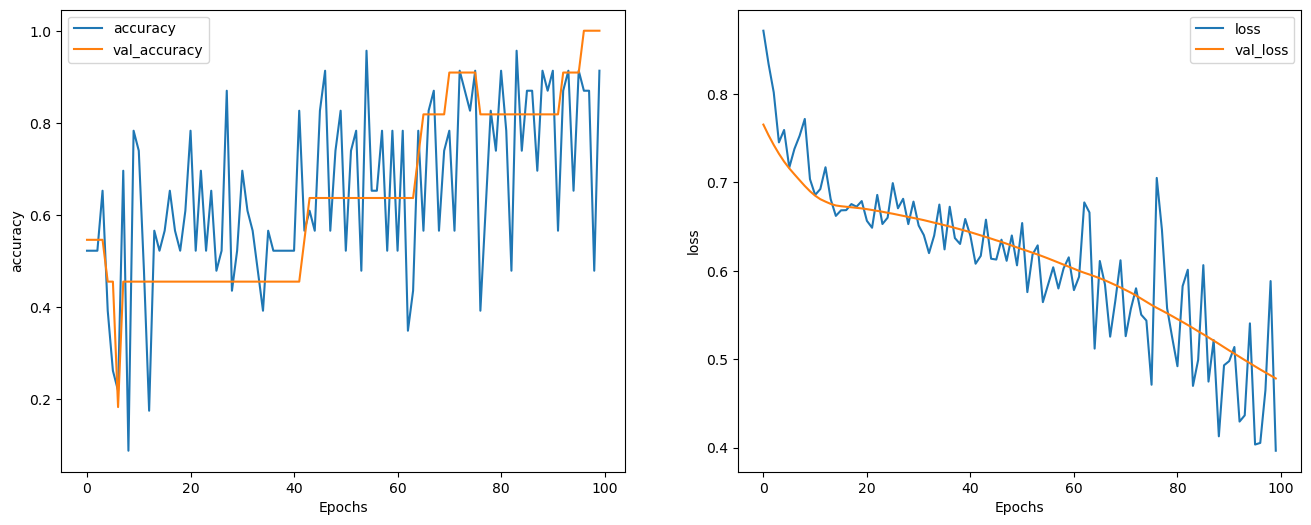

In [392]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history_club.history['accuracy'])
plt.plot(history_club.history['val_accuracy'], '')
plt.xlabel("Epochs")
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.subplot(1, 2, 2)
plt.plot(history_club.history['loss'])
plt.plot(history_club.history['val_loss'], '')
plt.xlabel("Epochs")
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])

# Citations

code from: https://github.com/danielegrattarola/spektral/blob/master/examples/node_prediction/citation_gcn.py

In [68]:
from spektral.datasets.citation import Citation
from tensorflow.keras.losses import CategoricalCrossentropy

dataset_cite = Citation('cora', normalize_x=True, transforms=[LayerPreprocess(GCNConv)])

def mask_to_weightsC(mask):
    return mask.astype(np.float32) / np.count_nonzero(mask)


weights_trC, weights_vaC, weights_teC = (
    mask_to_weightsC(mask)
    for mask in (dataset_cite.mask_tr, dataset_cite.mask_va, dataset_cite.mask_te)
)

learning_rate = 1e-2

model_cite = GCN(n_labels=dataset_cite.n_labels)
model_cite.compile(
    optimizer=Adam(learning_rate),
    loss=CategoricalCrossentropy(reduction="sum"),
    weighted_metrics=["accuracy"]
)


Pre-processing node features


/Users/kaitlynmcgrew/opt/anaconda3/lib/python3.9/site-packages/spektral/datasets/citation.py:108: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  a = nx.adjacency_matrix(nx.from_dict_of_lists(graph))  # CSR
/Users/kaitlynmcgrew/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [69]:
dataset_cite[0]

Graph(n_nodes=2708, n_node_features=1433, n_edge_features=None, n_labels=7)

In [70]:
# Train model
loader_trC = SingleLoader(dataset_cite, sample_weights=weights_trC)
loader_vaC = SingleLoader(dataset_cite, sample_weights=weights_vaC)
history_cite = model_cite.fit(
    loader_trC.load(),
    steps_per_epoch=loader_trC.steps_per_epoch,
    validation_data=loader_vaC.load(),
    validation_steps=loader_vaC.steps_per_epoch,
    epochs=epochs,
    callbacks=[EarlyStopping(patience=patience, restore_best_weights=True)],
)

Epoch 1/100
1/1 [==============================] - 1s 583ms/step - loss: 1.9543 - acc: 0.1071 - val_loss: 1.9503 - val_acc: 0.2720
Epoch 2/100
1/1 [==============================] - 0s 79ms/step - loss: 1.9472 - acc: 0.3286 - val_loss: 1.9466 - val_acc: 0.3380
Epoch 3/100
1/1 [==============================] - 0s 65ms/step - loss: 1.9402 - acc: 0.4929 - val_loss: 1.9423 - val_acc: 0.3840
Epoch 4/100
1/1 [==============================] - 0s 68ms/step - loss: 1.9340 - acc: 0.5643 - val_loss: 1.9380 - val_acc: 0.3940
Epoch 5/100
1/1 [==============================] - 0s 49ms/step - loss: 1.9250 - acc: 0.6571 - val_loss: 1.9342 - val_acc: 0.4100
Epoch 6/100
1/1 [==============================] - 0s 49ms/step - loss: 1.9160 - acc: 0.5786 - val_loss: 1.9307 - val_acc: 0.4160
Epoch 7/100
1/1 [==============================] - 0s 51ms/step - loss: 1.9083 - acc: 0.6286 - val_loss: 1.9273 - val_acc: 0.4240
Epoch 8/100
1/1 [==============================] - 0s 56ms/step - loss: 1.8992 - acc: 0.6

In [71]:
loader_fullC = SingleLoader(dataset_cite)
pred_cite = model_cite.predict(loader_fullC.load(), steps=loader_fullC.steps_per_epoch)

1/1 [==============================] - 0s 77ms/step


In [188]:
model_cite.evaluate(loader_fullC.load(), steps=loader_fullC.steps_per_epoch)

1/1 [==============================] - 1s 690ms/step - loss: 2634.9126 - acc: 0.8183


[2634.91259765625, 0.8183161020278931]

In [79]:
result_cite = pred_cite.argmax(axis=1)+1
labels_cite = dataset_cite[0].y.argmax(axis=1)+1

In [80]:
confusion_matrix(labels_cite, result_cite)

array([[289,   9,   8,  11,   7,   4,  23],
       [  6, 194,   6,   5,   0,   2,   4],
       [  7,  12, 392,   6,   0,   1,   0],
       [ 53,  31,  22, 620,  62,  11,  19],
       [ 37,   9,   3,  19, 338,  15,   5],
       [ 34,   5,   7,   1,   2, 230,  19],
       [ 15,   3,   0,   2,   1,   6, 153]])

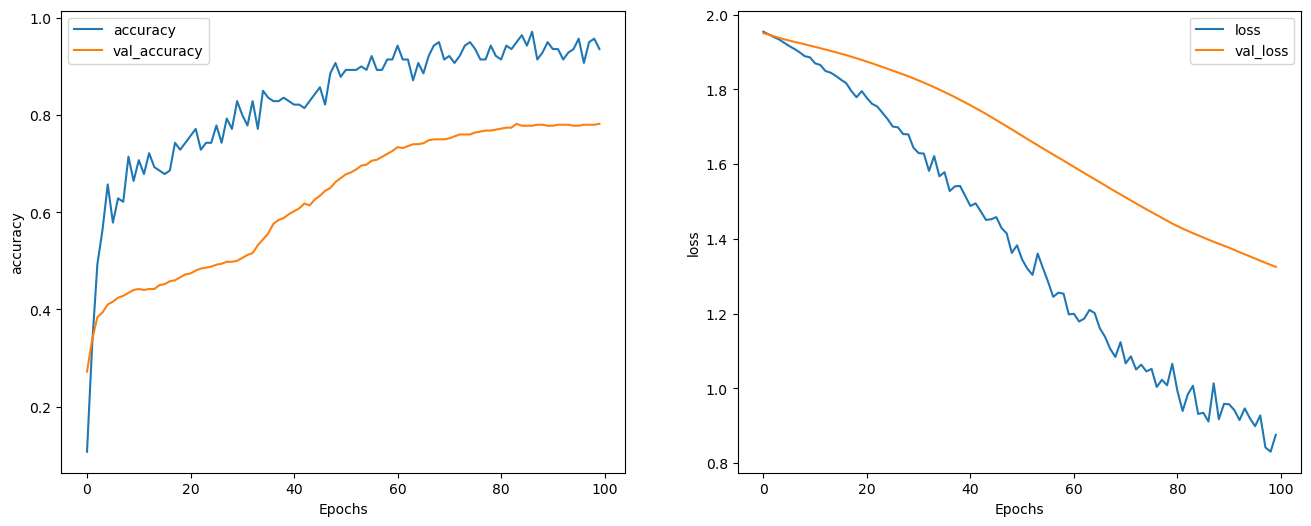

In [152]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history_cite.history['acc'])
plt.plot(history_cite.history['val_acc'], '')
plt.xlabel("Epochs")
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.subplot(1, 2, 2)
plt.plot(history_cite.history['loss'])
plt.plot(history_cite.history['val_loss'], '')
plt.xlabel("Epochs")
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])

In [83]:
G_cite = nx.from_numpy_matrix(dataset_cite[0].a)

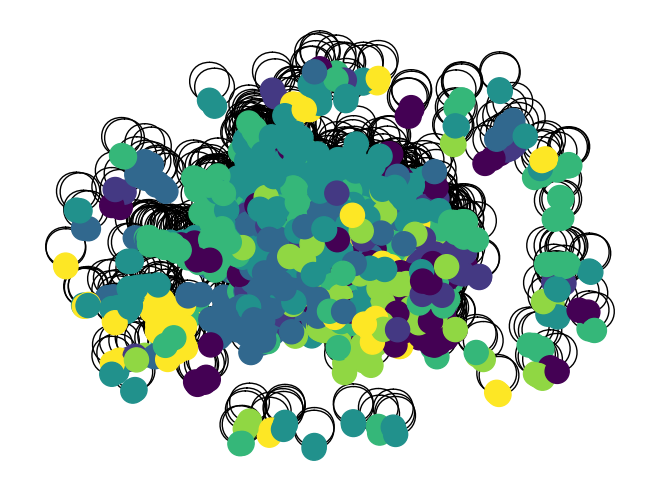

In [84]:
nx.draw(G_cite, node_color=result_cite)

# Complete Multipartite Graph
###  k-partite graph in which there is an edge between every pair of vertices from different independent sets.

No group is connected to it's own group, so network structure works against classification of node groups. Features remain correlated

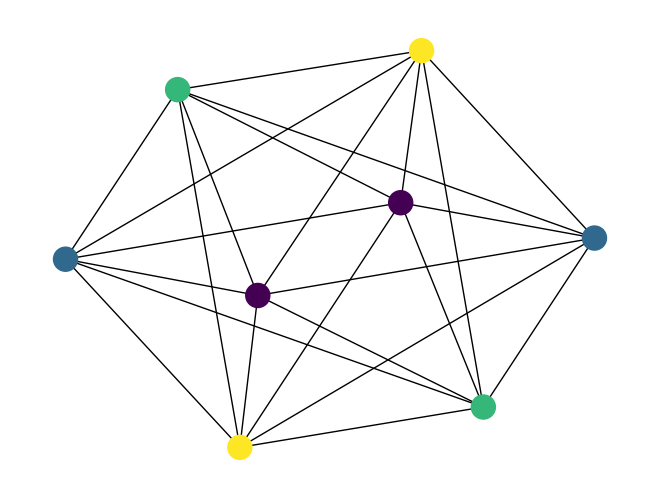

In [15]:
example_g_mult = nx.complete_multipartite_graph(2,2,2,2)
example_g_mult_labels = np.asarray([example_g_mult.nodes[u]["subset"] for u in example_g_mult]).astype(np.int64)
nx.draw(example_g_mult, node_color=example_g_mult_labels)

In [16]:
G_dum = nx.complete_multipartite_graph(1020, 1100, 1070, 1200, 1000)

In [17]:
labels_dum = np.asarray([G_dum.nodes[u]["subset"] for u in G_dum]).astype(np.int64)

In [18]:
features_dum = create_feature(labels_dum, 5)

In [19]:
class DummyDataset(Dataset):
    def __init__(self, nodes,feats, **kwargs):
        self.nodes = nodes
        self.feats = feats

        super().__init__(**kwargs)
        
    def read(self):
        output = []
        A = nx.to_numpy_array(G_dum)
        Y = labels_dum
        le = OneHotEncoder()
        YY = le.fit_transform(Y.reshape(-1,1))

        output.append(
            Graph(x=self.feats.astype("float32"),
                  a=A.astype('float32'), 
                  y=YY.astype('float32').todense()))

        return output

In [20]:
dataset_dum = DummyDataset(nodes=np.array(list(G_dum.nodes())),
                        feats=features_dum,
                        normalize_x=True,
                        transforms=LayerPreprocess(GCNConv))

In [21]:
dataset_dum[0]

Graph(n_nodes=5390, n_node_features=5, n_edge_features=None, n_labels=5)

In [22]:
dataset_dum[0].x

array([[0.9535433 , 0.8591309 , 0.89895415, 0.7558437 , 0.99107087],
       [0.98076177, 0.97412467, 0.9063246 , 0.95704925, 0.77767193],
       [0.9379553 , 0.99106187, 0.91374063, 0.87251353, 0.98932153],
       ...,
       [0.8952067 , 0.76889056, 0.94483364, 0.88305193, 0.7762522 ],
       [0.91685873, 0.86080354, 0.78410137, 0.84454   , 0.775248  ],
       [0.91026026, 0.9708632 , 0.84092754, 0.7568609 , 0.973458  ]],
      dtype=float32)

In [23]:
# create train and test masks
nodeD =  np.array(list(G_dum.nodes()))
n_nodesD = nodeD.shape[0]

X_trainD, X_testD, y_trainD, y_testD = train_test_split(pd.Series(nodeD), 
                                                    pd.Series(labels_dum), 
                                                    test_size=0.30, 
                                                    random_state=42)

train_maskD = torch.zeros(n_nodesD, dtype=torch.float32)
test_maskD = torch.zeros(n_nodesD, dtype=torch.float32)
train_maskD[X_trainD.index] = 1
test_maskD[X_testD.index] = 1

In [26]:
weights_trD, weights_teD = (mask_to_weights_torch(mask) for mask in (train_maskD, test_maskD))

In [27]:
loader_trD = SingleLoader(dataset_dum, sample_weights=weights_trD)
loader_teD = SingleLoader(dataset_dum, sample_weights=weights_teD)
loader_fullD = SingleLoader(dataset_dum)

In [32]:
learning_rate = 1e-1

model_dum = GCN(n_labels=dataset_dum.n_labels, channels=30, use_bias=True) 

model_dum.compile(optimizer=Adam(learning_rate),
              loss=BinaryCrossentropy(reduction='sum'),
              weighted_metrics=["accuracy"])

In [33]:
epochs = 100
patience = 10

In [34]:
history_dum = model_dum.fit(loader_trD.load(),
          steps_per_epoch=loader_trD.steps_per_epoch,
          epochs=epochs,
          validation_data=loader_teD.load(),
          validation_steps=loader_teD.steps_per_epoch,
         callbacks=[EarlyStopping(monitor="loss",patience=patience, restore_best_weights=True)])

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.8116 - accuracy: 0.2036 - val_loss: 0.6214 - val_accuracy: 0.2152
Epoch 2/100
1/1 [==============================] - 2s 2s/step - loss: 0.6214 - accuracy: 0.2258 - val_loss: 0.5528 - val_accuracy: 0.2016
Epoch 3/100
1/1 [==============================] - 2s 2s/step - loss: 0.5524 - accuracy: 0.1839 - val_loss: 0.5134 - val_accuracy: 0.2016
Epoch 4/100
1/1 [==============================] - 2s 2s/step - loss: 0.5154 - accuracy: 0.1839 - val_loss: 0.5240 - val_accuracy: 0.2016
Epoch 5/100
1/1 [==============================] - 2s 2s/step - loss: 0.5241 - accuracy: 0.1839 - val_loss: 0.5238 - val_accuracy: 0.2152
Epoch 6/100
1/1 [==============================] - 2s 2s/step - loss: 0.5243 - accuracy: 0.2258 - val_loss: 0.5121 - val_accuracy: 0.2152
Epoch 7/100
1/1 [==============================] - 2s 2s/step - loss: 0.5104 - accuracy: 0.2258 - val_loss: 0.5144 - val_accuracy: 0.2152
Epoch 8/100
1/1 [=================

In [148]:
pred_dum = model_dum.predict(loader_fullD.load(), steps=loader_fullD.steps_per_epoch)

1/1 [==============================] - 0s 355ms/step


In [150]:
result_dum = pred_dum.argmax(axis=1)
confusion_matrix(labels_dum, result_dum)

array([[250,   0,   0],
       [  0, 250,   0],
       [  0,   0, 250]])

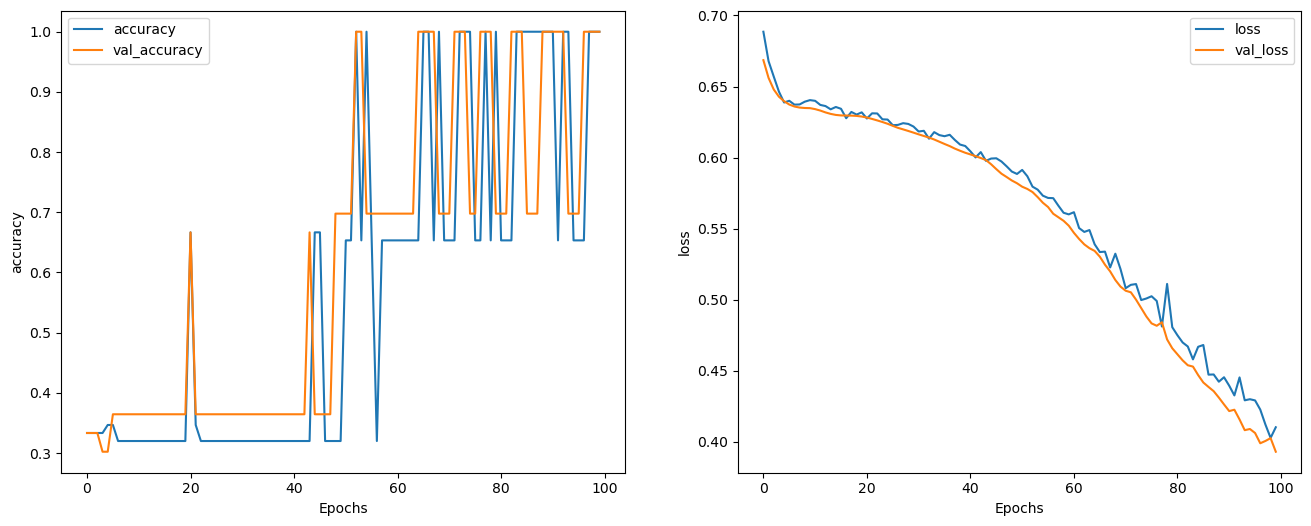

In [155]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history_dum.history['accuracy'])
plt.plot(history_dum.history['val_accuracy'], '')
plt.xlabel("Epochs")
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.subplot(1, 2, 2)
plt.plot(history_dum.history['loss'])
plt.plot(history_dum.history['val_loss'], '')
plt.xlabel("Epochs")
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])

# Testing Caveman

Caveman networks are individual cliques that are connected by one edge. Relaxed caveman networks have an extra parameter that is the probability of an edge randomly rewirring to a different clique. The higher the probability the more mixed and less distinct the cliques become.

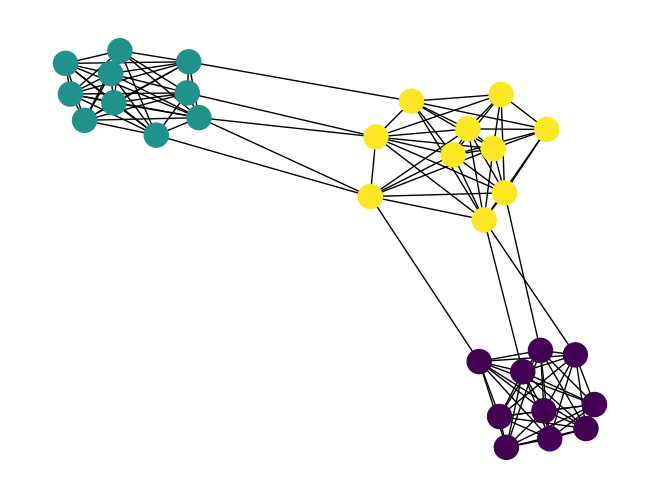

In [380]:
#Low Mixing
seed = 2

example_caveman = nx.relaxed_caveman_graph(3, 10, .1, seed=seed)
example_caveman = nx.convert_node_labels_to_integers(example_caveman, first_label=1)
example_label_values = ([1]*10)+([2]*10)+([3]*10)

nx.draw(example_caveman, node_color=example_label_values)

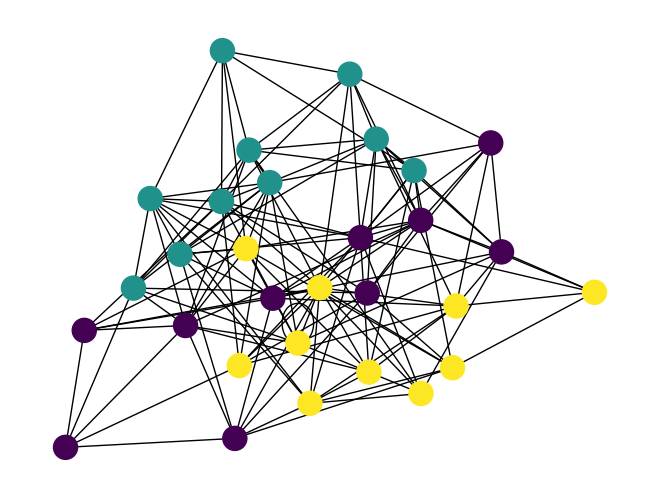

In [381]:
# High Mixing
example_caveman = nx.relaxed_caveman_graph(3, 10, .8, seed=seed)
example_caveman = nx.convert_node_labels_to_integers(example_caveman, first_label=1)
example_label_values = ([1]*10)+([2]*10)+([3]*10)

nx.draw(example_caveman, node_color=example_label_values)

In [378]:
example_labels = dict(zip(list(example_caveman.nodes), example_label_values))
nx.set_node_attributes(example_caveman, example_labels, 'category')

In [326]:
def edge_percent(graph):
    labels = nx.get_node_attributes(graph, 'category')
    total_edges = nx.number_of_edges(graph)
    edges_out = 0
    for node in graph.nodes:
        category = labels[node]
        connections = list(nx.all_neighbors(graph,node))
        for n in connections:
            if labels[n] != category:
                edges_out += 1     
    return  1 - (edges_out/2)/total_edges
        

#### Cave Datasets 10%

In [236]:
nodes_per_group = 1000
cave_01 = nx.relaxed_caveman_graph(3, nodes_per_group, .1, seed=seed)
cave_label = np.array(([0]*nodes_per_group)+([1]*nodes_per_group)+([2]*nodes_per_group))
cave_features = create_feature(cave_label, 15)

class CaveDataset_01(Dataset):
    def __init__(self, nodes,feats, **kwargs):
        self.nodes = nodes
        self.feats = feats

        super().__init__(**kwargs)
        
    def read(self):
        output = []
        A = nx.to_numpy_array(cave_01)
        Y = cave_label
        le = OneHotEncoder()
        YY = le.fit_transform(Y.reshape(-1,1))

        output.append(
            Graph(x=self.feats.astype("float32"),
                  a=A.astype('float32'), 
                  y=YY.astype('float32').todense()))
        return output

dataset_cave01 = CaveDataset_01(nodes=np.array(list(cave_01.nodes())),
                        feats=cave_features,
                        normalize_x=True,
                        transforms=LayerPreprocess(GCNConv))

learning_rate = 1e-2

model_cave01 = GCN(n_labels=dataset_cave01.n_labels, channels=12,  use_bias=True) 

model_cave01.compile(optimizer=Adam(learning_rate),
              loss=CategoricalCrossentropy(reduction='sum'),
              weighted_metrics=["accuracy"])

node =  np.array(list(cave_01.nodes()))
n_nodes = node.shape[0]

X_train, X_test, y_train, y_test = train_test_split(pd.Series(node), 
                                                    pd.Series(cave_label), 
                                                    test_size=0.20, 
                                                    random_state=42)

train_mask = torch.zeros(n_nodes, dtype=torch.float32)
test_mask = torch.zeros(n_nodes, dtype=torch.float32)
train_mask[X_train.index] = 1
test_mask[X_test.index] = 1

weights_tr_cave, weights_te_cave = (mask_to_weights_torch(mask) for mask in (train_mask, test_mask))

loader_tr_cave01 = SingleLoader(dataset_cave01, sample_weights=weights_tr_cave)
loader_te_cave01 = SingleLoader(dataset_cave01, sample_weights=weights_te_cave)

In [382]:
model_cave01.summary()

Model: "gcn_94"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_188 (Dropout)       multiple                  0         
                                                                 
 gcn_conv_188 (GCNConv)      multiple                  192       
                                                                 
 dropout_189 (Dropout)       multiple                  0         
                                                                 
 gcn_conv_189 (GCNConv)      multiple                  39        
                                                                 
Total params: 231
Trainable params: 231
Non-trainable params: 0
_________________________________________________________________


In [237]:
epochs = 100
patience = 10

history_01 = model_cave01.fit(loader_tr_cave01.load(),
          steps_per_epoch=loader_tr_cave01.steps_per_epoch,
          epochs=epochs,
          validation_data=loader_te_cave01.load(),
         validation_steps=loader_te_cave01.steps_per_epoch,
         callbacks=[EarlyStopping(monitor="val_loss",patience=patience, restore_best_weights=True)])

Epoch 1/100
1/1 [==============================] - 1s 724ms/step - loss: 1.2206 - accuracy: 0.3346 - val_loss: 1.1742 - val_accuracy: 0.3283
Epoch 2/100
1/1 [==============================] - 0s 164ms/step - loss: 1.1828 - accuracy: 0.3346 - val_loss: 1.1438 - val_accuracy: 0.3283
Epoch 3/100
1/1 [==============================] - 0s 180ms/step - loss: 1.1509 - accuracy: 0.3346 - val_loss: 1.1283 - val_accuracy: 0.3283
Epoch 4/100
1/1 [==============================] - 0s 168ms/step - loss: 1.1316 - accuracy: 0.3346 - val_loss: 1.1037 - val_accuracy: 0.0000e+00
Epoch 5/100
1/1 [==============================] - 0s 174ms/step - loss: 1.1150 - accuracy: 0.0067 - val_loss: 1.0918 - val_accuracy: 0.3617
Epoch 6/100
1/1 [==============================] - 0s 176ms/step - loss: 1.0975 - accuracy: 0.3263 - val_loss: 1.0889 - val_accuracy: 0.3617
Epoch 7/100
1/1 [==============================] - 0s 172ms/step - loss: 1.0972 - accuracy: 0.3263 - val_loss: 1.0868 - val_accuracy: 0.3617
Epoch 8/1

In [329]:
loader_fullCave01 = SingleLoader(dataset_cave01)
pred_cave01 = model_cave01.predict(loader_fullCave.load(), steps=loader_fullCave.steps_per_epoch)
result_cave01 = pred_cave01.argmax(axis=1)
confusion_matrix(cave_label, result_cave01)

1/1 [==============================] - 0s 121ms/step


array([[1000,    0,    0],
       [   0, 1000,    0],
       [   0,    0, 1000]])

In [330]:
acc_01 = model_cave01.evaluate(loader_fullCave01.load(), steps=loader_fullCave01.steps_per_epoch)

1/1 [==============================] - 1s 859ms/step - loss: 718.8300 - accuracy: 1.0000


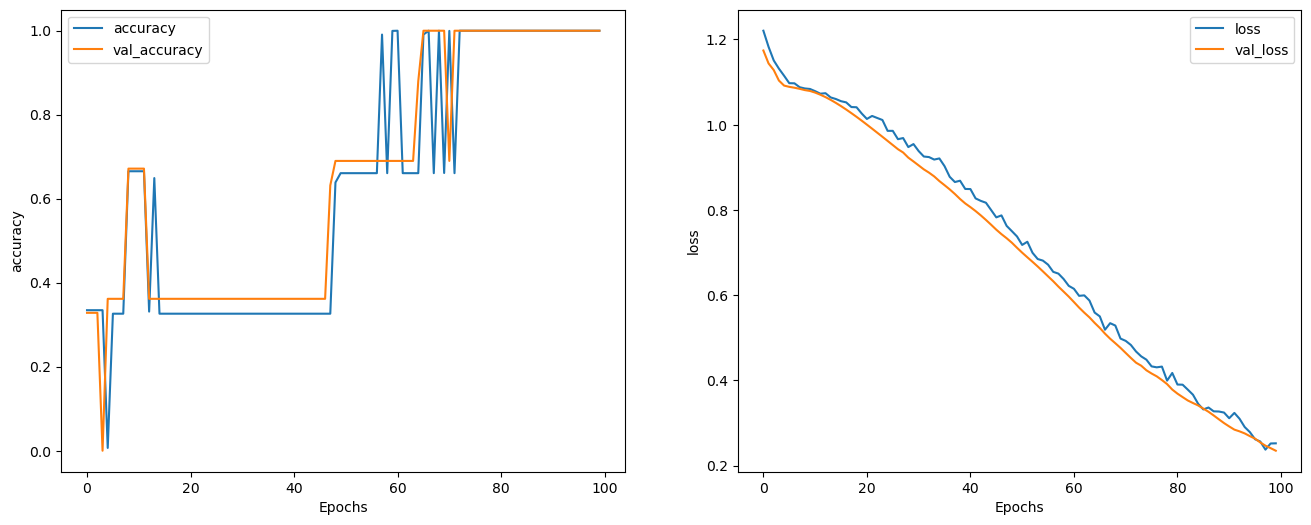

In [240]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history_01.history['accuracy'])
plt.plot(history_01.history['val_accuracy'], '')
plt.xlabel("Epochs")
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.subplot(1, 2, 2)
plt.plot(history_01.history['loss'])
plt.plot(history_01.history['val_loss'], '')
plt.xlabel("Epochs")
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])

#### Caveman Dataset 40%

In [242]:
cave_2 = nx.relaxed_caveman_graph(3, nodes_per_group, .4, seed=seed)


class CaveDataset_2(Dataset):
    def __init__(self, nodes,feats, **kwargs):
        self.nodes = nodes
        self.feats = feats

        super().__init__(**kwargs)
        
    def read(self):
        output = []
        A = nx.to_numpy_array(cave_2)
        Y = cave_label
        le = OneHotEncoder()
        YY = le.fit_transform(Y.reshape(-1,1))

        output.append(
            Graph(x=self.feats.astype("float32"),
                  a=A.astype('float32'), 
                  y=YY.astype('float32').todense()))
        return output

dataset_cave2 = CaveDataset_2(nodes=np.array(list(cave_2.nodes())),
                        feats=cave_features,
                        normalize_x=True,
                        transforms=LayerPreprocess(GCNConv))

learning_rate = 1e-2

model_cave2 = GCN(n_labels=dataset_cave2.n_labels, channels=12,  use_bias=True) 

model_cave2.compile(optimizer=Adam(learning_rate),
              loss=CategoricalCrossentropy(reduction='sum'),
              weighted_metrics=["accuracy"])

node =  np.array(list(cave_2.nodes()))
n_nodes = node.shape[0]

X_train, X_test, y_train, y_test = train_test_split(pd.Series(node), 
                                                    pd.Series(cave_label), 
                                                    test_size=0.20, 
                                                    random_state=42)

train_mask = torch.zeros(n_nodes, dtype=torch.float32)
test_mask = torch.zeros(n_nodes, dtype=torch.float32)
train_mask[X_train.index] = 1
test_mask[X_test.index] = 1

weights_tr_cave, weights_te_cave = (mask_to_weights_torch(mask) for mask in (train_mask, test_mask))

loader_tr_cave2 = SingleLoader(dataset_cave2, sample_weights=weights_tr_cave)
loader_te_cave2 = SingleLoader(dataset_cave2, sample_weights=weights_te_cave)

In [243]:
history_2 = model_cave2.fit(loader_tr_cave2.load(),
          steps_per_epoch=loader_tr_cave2.steps_per_epoch,
          epochs=epochs,
          validation_data=loader_te_cave2.load(),
         validation_steps=loader_te_cave2.steps_per_epoch,
         callbacks=[EarlyStopping(monitor="val_loss",patience=patience, restore_best_weights=True)])

Epoch 1/100
1/1 [==============================] - 1s 707ms/step - loss: 1.3600 - accuracy: 0.3346 - val_loss: 1.2752 - val_accuracy: 0.3283
Epoch 2/100
1/1 [==============================] - 0s 165ms/step - loss: 1.2776 - accuracy: 0.3346 - val_loss: 1.2027 - val_accuracy: 0.3283
Epoch 3/100
1/1 [==============================] - 0s 165ms/step - loss: 1.1927 - accuracy: 0.3346 - val_loss: 1.1483 - val_accuracy: 0.3283
Epoch 4/100
1/1 [==============================] - 0s 158ms/step - loss: 1.1402 - accuracy: 0.3104 - val_loss: 1.1099 - val_accuracy: 0.3617
Epoch 5/100
1/1 [==============================] - 0s 164ms/step - loss: 1.1167 - accuracy: 0.3250 - val_loss: 1.0847 - val_accuracy: 0.3617
Epoch 6/100
1/1 [==============================] - 0s 160ms/step - loss: 1.0887 - accuracy: 0.3263 - val_loss: 1.0698 - val_accuracy: 0.3617
Epoch 7/100
1/1 [==============================] - 0s 160ms/step - loss: 1.0777 - accuracy: 0.3263 - val_loss: 1.0594 - val_accuracy: 0.3617
Epoch 8/100
1

In [244]:
loader_fullCave2 = SingleLoader(dataset_cave2)
pred_cave2 = model_cave2.predict(loader_fullCave2.load(), steps=loader_fullCave2.steps_per_epoch)
result_cave2 = pred_cave2.argmax(axis=1)
confusion_matrix(cave_label, result_cave2)

1/1 [==============================] - 0s 94ms/step


array([[1000,    0,    0],
       [   0, 1000,    0],
       [   0,    0, 1000]])

In [331]:
acc_2 = model_cave2.evaluate(loader_fullCave2.load(), steps=loader_fullCave2.steps_per_epoch)

1/1 [==============================] - 0s 231ms/step - loss: 1267.7582 - accuracy: 1.0000


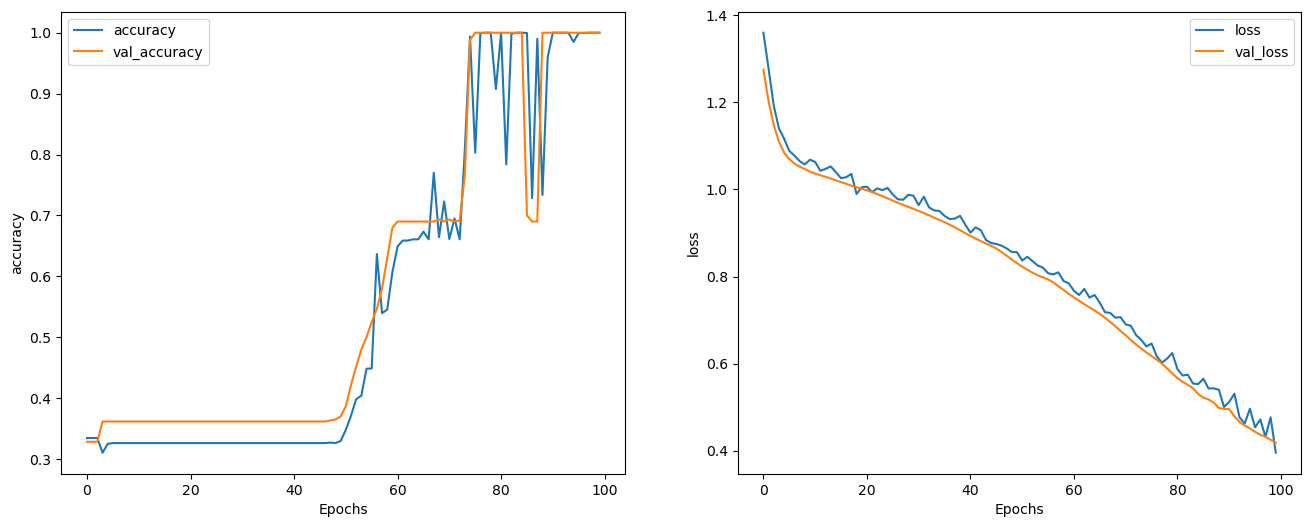

In [245]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'], '')
plt.xlabel("Epochs")
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.subplot(1, 2, 2)
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'], '')
plt.xlabel("Epochs")
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])

#### Caveman Datasets 80%

In [264]:
cave_4 = nx.relaxed_caveman_graph(3, nodes_per_group, .8, seed=seed)


class CaveDataset_4(Dataset):
    def __init__(self, nodes,feats, **kwargs):
        self.nodes = nodes
        self.feats = feats

        super().__init__(**kwargs)
        
    def read(self):
        output = []
        A = nx.to_numpy_array(cave_4)
        Y = cave_label
        le = OneHotEncoder()
        YY = le.fit_transform(Y.reshape(-1,1))

        output.append(
            Graph(x=self.feats.astype("float32"),
                  a=A.astype('float32'), 
                  y=YY.astype('float32').todense()))
        return output

dataset_cave4 = CaveDataset_4(nodes=np.array(list(cave_4.nodes())),
                        feats=cave_features,
                        normalize_x=True,
                        transforms=LayerPreprocess(GCNConv))

learning_rate = 1e-2

model_cave4 = GCN(n_labels=dataset_cave4.n_labels, channels=12,  use_bias=True) 

model_cave4.compile(optimizer=Adam(learning_rate),
              loss=CategoricalCrossentropy(reduction='sum'),
              weighted_metrics=["accuracy"])

node =  np.array(list(cave_4.nodes()))
n_nodes = node.shape[0]

X_train, X_test, y_train, y_test = train_test_split(pd.Series(node), 
                                                    pd.Series(cave_label), 
                                                    test_size=0.20, 
                                                    random_state=42)

train_mask = torch.zeros(n_nodes, dtype=torch.float32)
test_mask = torch.zeros(n_nodes, dtype=torch.float32)
train_mask[X_train.index] = 1
test_mask[X_test.index] = 1

weights_tr_cave, weights_te_cave = (mask_to_weights_torch(mask) for mask in (train_mask, test_mask))

loader_tr_cave4 = SingleLoader(dataset_cave4, sample_weights=weights_tr_cave)
loader_te_cave4 = SingleLoader(dataset_cave4, sample_weights=weights_te_cave)

In [265]:
history_4 = model_cave4.fit(loader_tr_cave4.load(),
          steps_per_epoch=loader_tr_cave4.steps_per_epoch,
          epochs=epochs,
          validation_data=loader_te_cave4.load(),
         validation_steps=loader_te_cave4.steps_per_epoch,
         callbacks=[EarlyStopping(monitor="val_loss",patience=patience, restore_best_weights=True)])

Epoch 1/100
1/1 [==============================] - 1s 673ms/step - loss: 1.1156 - accuracy: 0.3392 - val_loss: 1.1144 - val_accuracy: 0.3100
Epoch 2/100
1/1 [==============================] - 0s 163ms/step - loss: 1.1083 - accuracy: 0.3467 - val_loss: 1.1018 - val_accuracy: 0.3100
Epoch 3/100
1/1 [==============================] - 0s 162ms/step - loss: 1.1016 - accuracy: 0.3392 - val_loss: 1.0961 - val_accuracy: 0.3617
Epoch 4/100
1/1 [==============================] - 0s 159ms/step - loss: 1.1004 - accuracy: 0.3263 - val_loss: 1.0953 - val_accuracy: 0.3617
Epoch 5/100
1/1 [==============================] - 0s 157ms/step - loss: 1.1012 - accuracy: 0.3263 - val_loss: 1.0943 - val_accuracy: 0.3617
Epoch 6/100
1/1 [==============================] - 0s 160ms/step - loss: 1.1038 - accuracy: 0.3263 - val_loss: 1.0932 - val_accuracy: 0.3617
Epoch 7/100
1/1 [==============================] - 0s 160ms/step - loss: 1.1002 - accuracy: 0.3263 - val_loss: 1.0940 - val_accuracy: 0.3617
Epoch 8/100
1

In [266]:
loader_fullCave4 = SingleLoader(dataset_cave4)
pred_cave4 = model_cave4.predict(loader_fullCave4.load(), steps=loader_fullCave4.steps_per_epoch)
result_cave4 = pred_cave4.argmax(axis=1)
confusion_matrix(cave_label, result_cave4)

1/1 [==============================] - 0s 94ms/step


array([[1000,    0,    0],
       [   0,  996,    4],
       [ 206,    0,  794]])

In [332]:
acc_4 = model_cave4.evaluate(loader_fullCave4.load(), steps=loader_fullCave4.steps_per_epoch)

1/1 [==============================] - 0s 316ms/step - loss: 2599.4709 - accuracy: 0.9300


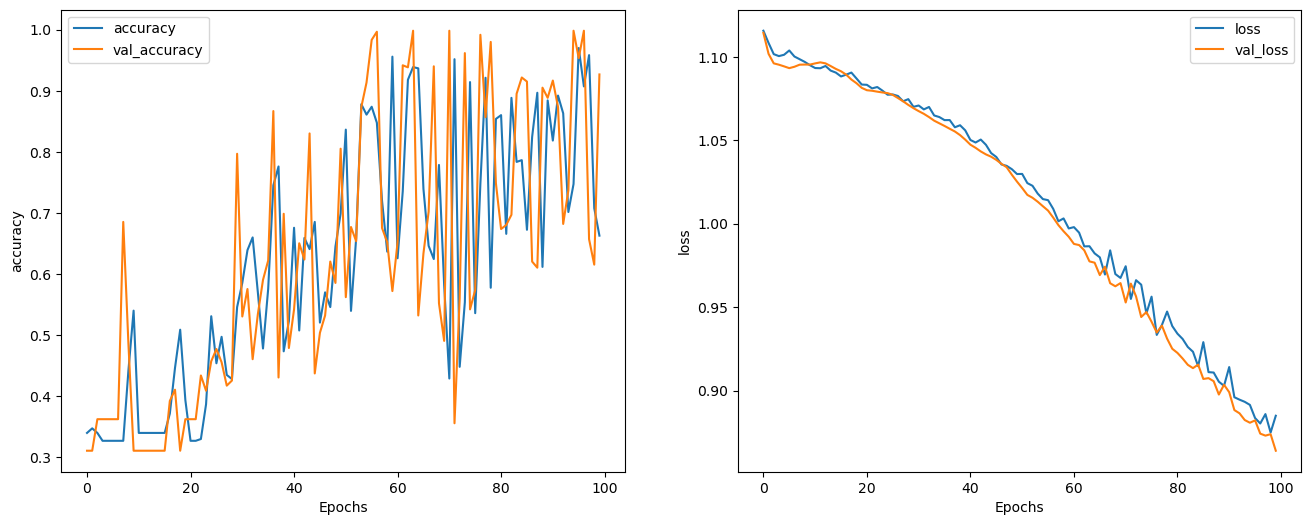

In [267]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history_4.history['accuracy'])
plt.plot(history_4.history['val_accuracy'], '')
plt.xlabel("Epochs")
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.subplot(1, 2, 2)
plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'], '')
plt.xlabel("Epochs")
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])

#### Caveman Dataset 85%

In [335]:
cave_6 = nx.relaxed_caveman_graph(3, nodes_per_group, .85, seed=seed)


class CaveDataset_6(Dataset):
    def __init__(self, nodes,feats, **kwargs):
        self.nodes = nodes
        self.feats = feats

        super().__init__(**kwargs)
        
    def read(self):
        output = []
        A = nx.to_numpy_array(cave_6)
        Y = cave_label
        le = OneHotEncoder()
        YY = le.fit_transform(Y.reshape(-1,1))

        output.append(
            Graph(x=self.feats.astype("float32"),
                  a=A.astype('float32'), 
                  y=YY.astype('float32').todense()))
        return output

dataset_cave6 = CaveDataset_6(nodes=np.array(list(cave_6.nodes())),
                        feats=cave_features,
                        normalize_x=True,
                        transforms=LayerPreprocess(GCNConv))

learning_rate = 1e-2

model_cave6 = GCN(n_labels=dataset_cave6.n_labels, channels=12,  use_bias=True) 

model_cave6.compile(optimizer=Adam(learning_rate),
              loss=CategoricalCrossentropy(reduction='sum'),
              weighted_metrics=["accuracy"])

node =  np.array(list(cave_6.nodes()))
n_nodes = node.shape[0]

X_train, X_test, y_train, y_test = train_test_split(pd.Series(node), 
                                                    pd.Series(cave_label), 
                                                    test_size=0.20, 
                                                    random_state=42)

train_mask = torch.zeros(n_nodes, dtype=torch.float32)
test_mask = torch.zeros(n_nodes, dtype=torch.float32)
train_mask[X_train.index] = 1
test_mask[X_test.index] = 1

weights_tr_cave, weights_te_cave = (mask_to_weights_torch(mask) for mask in (train_mask, test_mask))

loader_tr_cave6 = SingleLoader(dataset_cave6, sample_weights=weights_tr_cave)
loader_te_cave6 = SingleLoader(dataset_cave6, sample_weights=weights_te_cave)

In [339]:
history_6 = model_cave6.fit(loader_tr_cave6.load(),
          steps_per_epoch=loader_tr_cave6.steps_per_epoch,
          epochs=epochs,
          validation_data=loader_te_cave6.load(),
         validation_steps=loader_te_cave6.steps_per_epoch,
         callbacks=[EarlyStopping(monitor="val_loss",patience=patience, restore_best_weights=True)])

Epoch 1/100
1/1 [==============================] - 0s 202ms/step - loss: 1.0936 - accuracy: 0.3263 - val_loss: 1.0928 - val_accuracy: 0.3617
Epoch 2/100
1/1 [==============================] - 0s 168ms/step - loss: 1.1019 - accuracy: 0.3258 - val_loss: 1.0923 - val_accuracy: 0.3617
Epoch 3/100
1/1 [==============================] - 0s 173ms/step - loss: 1.0967 - accuracy: 0.3263 - val_loss: 1.0921 - val_accuracy: 0.3617
Epoch 4/100
1/1 [==============================] - 0s 165ms/step - loss: 1.0984 - accuracy: 0.3263 - val_loss: 1.0920 - val_accuracy: 0.3617
Epoch 5/100
1/1 [==============================] - 0s 165ms/step - loss: 1.0987 - accuracy: 0.3263 - val_loss: 1.0922 - val_accuracy: 0.3617
Epoch 6/100
1/1 [==============================] - 0s 165ms/step - loss: 1.0972 - accuracy: 0.3242 - val_loss: 1.0928 - val_accuracy: 0.3617
Epoch 7/100
1/1 [==============================] - 0s 164ms/step - loss: 1.0950 - accuracy: 0.3308 - val_loss: 1.0934 - val_accuracy: 0.3683
Epoch 8/100
1

In [338]:
loader_fullCave6 = SingleLoader(dataset_cave6)
pred_cave6 = model_cave6.predict(loader_fullCave6.load(), steps=loader_fullCave6.steps_per_epoch)
result_cave6 = pred_cave6.argmax(axis=1)
confusion_matrix(cave_label, result_cave6)

1/1 [==============================] - 0s 136ms/step


array([[1000,    0,    0],
       [1000,    0,    0],
       [1000,    0,    0]])

In [344]:
acc_6 = model_cave6.evaluate(loader_fullCave6.load(), steps=loader_fullCave6.steps_per_epoch)

1/1 [==============================] - 0s 231ms/step - loss: 3275.4951 - accuracy: 0.3333


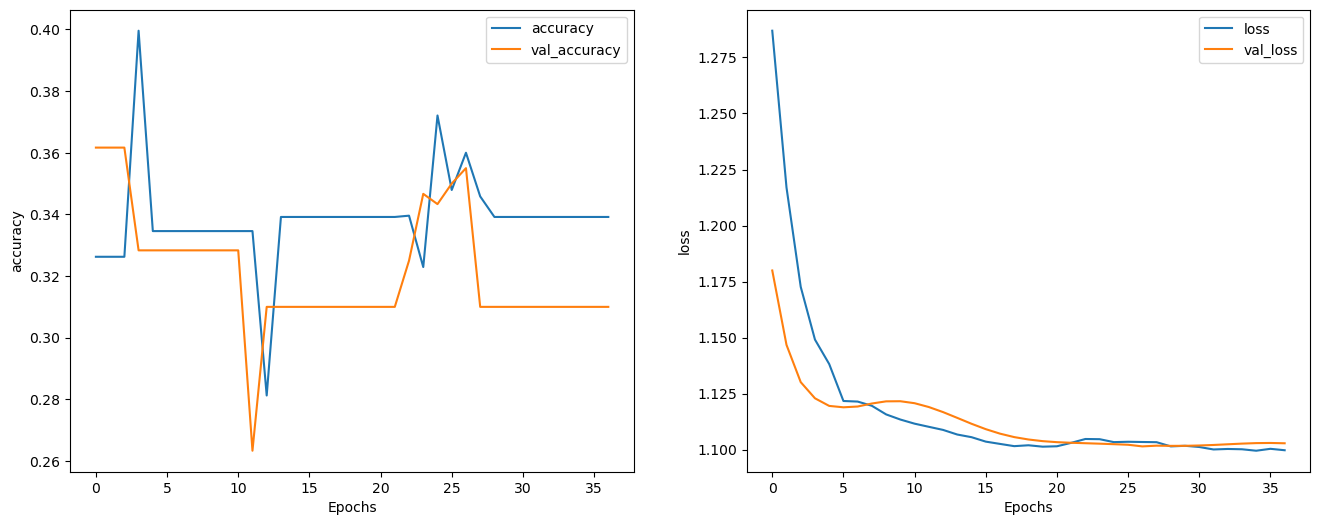

In [310]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history_6.history['accuracy'])
plt.plot(history_6.history['val_accuracy'], '')
plt.xlabel("Epochs")
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.subplot(1, 2, 2)
plt.plot(history_6.history['loss'])
plt.plot(history_6.history['val_loss'], '')
plt.xlabel("Epochs")
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])

#### Caveman Dataset 90%

In [340]:
cave_8 = nx.relaxed_caveman_graph(3, nodes_per_group, .9, seed=seed)


class CaveDataset_8(Dataset):
    def __init__(self, nodes,feats, **kwargs):
        self.nodes = nodes
        self.feats = feats

        super().__init__(**kwargs)
        
    def read(self):
        output = []
        A = nx.to_numpy_array(cave_8)
        Y = cave_label
        le = OneHotEncoder()
        YY = le.fit_transform(Y.reshape(-1,1))

        output.append(
            Graph(x=self.feats.astype("float32"),
                  a=A.astype('float32'), 
                  y=YY.astype('float32').todense()))
        return output

dataset_cave8 = CaveDataset_8(nodes=np.array(list(cave_8.nodes())),
                        feats=cave_features,
                        normalize_x=True,
                        transforms=LayerPreprocess(GCNConv))

learning_rate = 1e-2

model_cave8 = GCN(n_labels=dataset_cave6.n_labels, channels=12,  use_bias=True) 

model_cave8.compile(optimizer=Adam(learning_rate),
              loss=CategoricalCrossentropy(reduction='sum'),
              weighted_metrics=["accuracy"])

node =  np.array(list(cave_8.nodes()))
n_nodes = node.shape[0]

X_train, X_test, y_train, y_test = train_test_split(pd.Series(node), 
                                                    pd.Series(cave_label), 
                                                    test_size=0.20, 
                                                    random_state=42)

train_mask = torch.zeros(n_nodes, dtype=torch.float32)
test_mask = torch.zeros(n_nodes, dtype=torch.float32)
train_mask[X_train.index] = 1
test_mask[X_test.index] = 1

weights_tr_cave, weights_te_cave = (mask_to_weights_torch(mask) for mask in (train_mask, test_mask))

loader_tr_cave8 = SingleLoader(dataset_cave8, sample_weights=weights_tr_cave)
loader_te_cave8 = SingleLoader(dataset_cave8, sample_weights=weights_te_cave)

In [341]:
history_8 = model_cave6.fit(loader_tr_cave8.load(),
          steps_per_epoch=loader_tr_cave8.steps_per_epoch,
          epochs=epochs,
          validation_data=loader_te_cave8.load(),
         validation_steps=loader_te_cave8.steps_per_epoch,
         callbacks=[EarlyStopping(monitor="val_loss",patience=patience, restore_best_weights=True)])

Epoch 1/100
1/1 [==============================] - 0s 393ms/step - loss: 1.1029 - accuracy: 0.3263 - val_loss: 1.0952 - val_accuracy: 0.3617
Epoch 2/100
1/1 [==============================] - 0s 213ms/step - loss: 1.0968 - accuracy: 0.3333 - val_loss: 1.0952 - val_accuracy: 0.3617
Epoch 3/100
1/1 [==============================] - 0s 175ms/step - loss: 1.0992 - accuracy: 0.3271 - val_loss: 1.0956 - val_accuracy: 0.3633
Epoch 4/100
1/1 [==============================] - 0s 174ms/step - loss: 1.0944 - accuracy: 0.4325 - val_loss: 1.0962 - val_accuracy: 0.3100
Epoch 5/100
1/1 [==============================] - 0s 172ms/step - loss: 1.0955 - accuracy: 0.3571 - val_loss: 1.0970 - val_accuracy: 0.3100
Epoch 6/100
1/1 [==============================] - 0s 159ms/step - loss: 1.0982 - accuracy: 0.3017 - val_loss: 1.0975 - val_accuracy: 0.3100
Epoch 7/100
1/1 [==============================] - 0s 219ms/step - loss: 1.0959 - accuracy: 0.3396 - val_loss: 1.0980 - val_accuracy: 0.3100
Epoch 8/100
1

In [342]:
loader_fullCave8 = SingleLoader(dataset_cave8)
pred_cave8 = model_cave8.predict(loader_fullCave8.load(), steps=loader_fullCave8.steps_per_epoch)
result_cave8 = pred_cave8.argmax(axis=1)
confusion_matrix(cave_label, result_cave8)

1/1 [==============================] - 0s 189ms/step


array([[   0,    0, 1000],
       [   0,    0, 1000],
       [   0,    0, 1000]])

In [343]:
acc_8 = model_cave8.evaluate(loader_fullCave8.load(), steps=loader_fullCave8.steps_per_epoch)

1/1 [==============================] - 0s 436ms/step - loss: 3704.3875 - accuracy: 0.3333


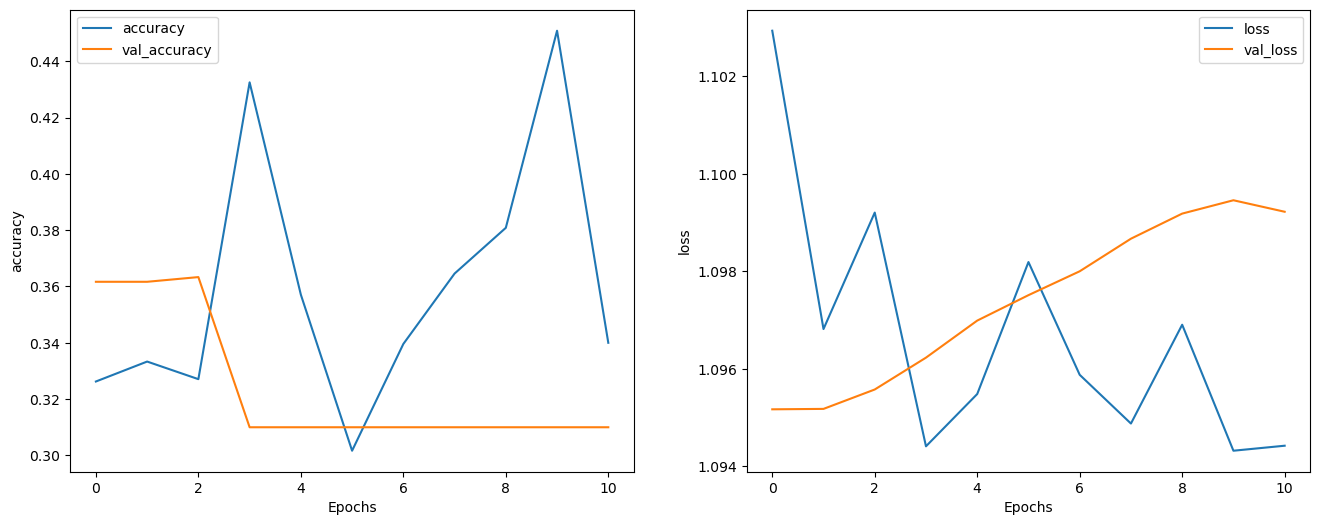

In [345]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history_8.history['accuracy'])
plt.plot(history_8.history['val_accuracy'], '')
plt.xlabel("Epochs")
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.subplot(1, 2, 2)
plt.plot(history_8.history['loss'])
plt.plot(history_8.history['val_loss'], '')
plt.xlabel("Epochs")
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])

#### Comparing Models

In [346]:
labels = dict(zip(list(cave_01.nodes), cave_label))

graphs = [cave_01, cave_2, cave_4, cave_6, cave_8]
for x in graphs:
    nx.set_node_attributes(x, labels, 'category')

In [368]:
percents = [edge_percent(graph) for graph in graphs]
accs = [acc_01[1], acc_2[1], acc_4[1], acc_6[1], acc_8[1]]

Text(0, 0.5, 'Accuracy')

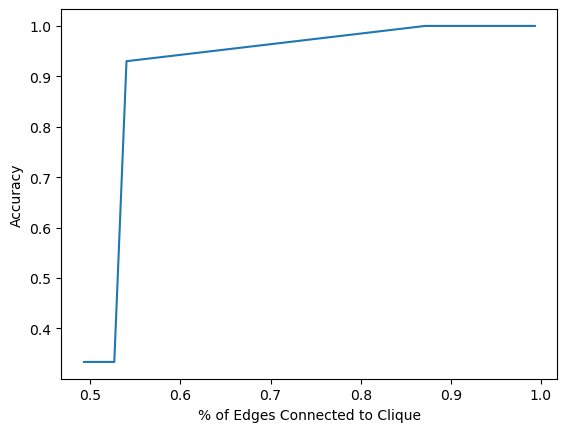

In [373]:
li = list(zip(percents, accs))
plt.plot(percents, accs)
plt.xlabel("% of Edges Connected to Clique")
plt.ylabel('Accuracy')


In [384]:
accs

[1.0, 1.0, 0.9300000071525574, 0.3333333432674408, 0.3333333432674408]

In [ ]:
percents

[0.9932452452452453,
 0.871638972305639,
 0.54009009009009,
 0.5265485485485486,
 0.4928775442108776]